# Installation

In [ ]:
# !pip install controlnet_aux
# !pip install diffusers transformers accelerate pillow torch

In [8]:
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import MLSDdetector
from controlnet_aux import HEDdetector

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-05-09 12:09:32.975306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 12:09:32.975396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 12:09:33.090814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [9]:
# adapted from https://huggingface.co/lllyasviel/sd-controlnet-mlsd
class SketchToImage():
    
    def __init__(self, detector):
        
        if detector not in ['scribble', 'mlsd', 'hed']:
            
            raise Exception(f'{detector} detector not implemented')
            
        self.detector = detector
        
        # init detector
        if detector == 'mlsd':
            self.detector = MLSDdetector.from_pretrained('lllyasviel/ControlNet')

        else:
            self.detector = HEDdetector.from_pretrained('lllyasviel/ControlNet')
        
        # init controlNet image generator
        self.controlnet= ControlNetModel.from_pretrained(
            f"lllyasviel/sd-controlnet-{detector}", 
            torch_dtype=torch.float16
        )
        
        # defining model pipeline
        self.pipe = StableDiffusionControlNetPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5", 
            controlnet=self.controlnet, 
            safety_checker=None, 
            torch_dtype=torch.float16
        )
        self.pipe.scheduler = UniPCMultistepScheduler.from_config(self.pipe.scheduler.config)
        self.pipe.enable_model_cpu_offload()


    def generate_lines(self, image, outfile):
        
        if self.detector == 'scribble':
            image = self.detector(image, scribble = True)
        else:
            image = self.detector(image)

        image.save('images/'+ outfile + '_lines.png')

        return image 
    
    def generate_image(self, image, prompt, outfile):
    
        image = self.pipe(
            prompt, 
            image, 
            num_inference_steps=20
        ).images[0]

        # prompt engineering: figure out best formats to get good spacing for extra inpainting
        image.save('images/' + outfile + '_out.png')
        
        return image
    
    def generate_image_from_sketch(self, image_path, prompt, outfile):
        
        image = Image.open(image_path)
        image = self.generate_image(image, prompt, outfile)
        
        return image
        
    def generate_image_from_sample(self, image_path, prompt, outfile):
        
        image = Image.open(image_path)
        image = self.generate_lines(image, outfile)
        image = self.generate_image(image, prompt, outfile)
        
        return image

In [ ]:
model = SketchToImage('mlsd')

In [11]:
image = model.generate_image_from_sample(
    image_path = '/kaggle/input/mlsd-lines/street_path_in.png',
    prompt = 'street path, color, animated',
    outfile = 'hotel_lobby'
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

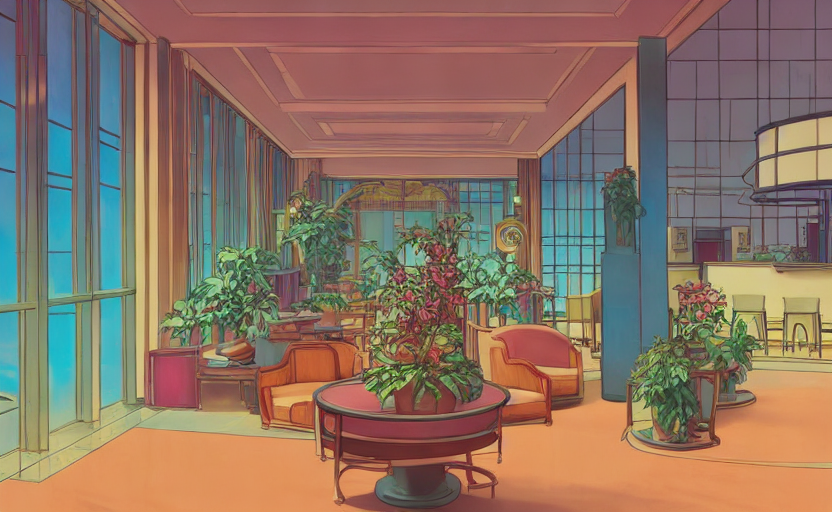

In [13]:
image = model.generate_image_from_sample(
    image_path = '/kaggle/input/mlsd-lines/hotel_lobby_in.jpg',
    prompt = 'hotel lobby, color, studio ghibli',
    outfile = 'hotel_lobby'
)

Image.open('/kaggle/working/images/hotel_lobby_out.png')

  0%|          | 0/20 [00:00<?, ?it/s]

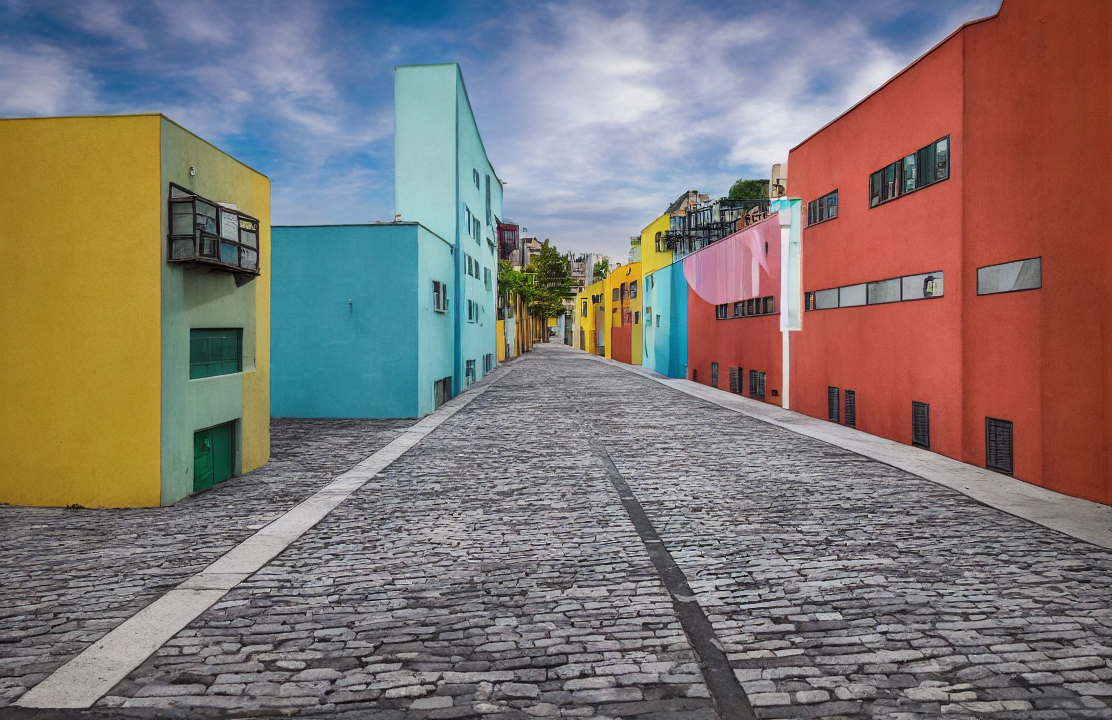

In [16]:
image = model.generate_image_from_sketch(
    image_path = '/kaggle/input/mlsd-lines/apartment_lines.jpg',
    prompt = 'street path with apartments, color, real',
    outfile = 'apartments'
)

Image.open('/kaggle/working/images/apartments_out.png')

  0%|          | 0/20 [00:00<?, ?it/s]

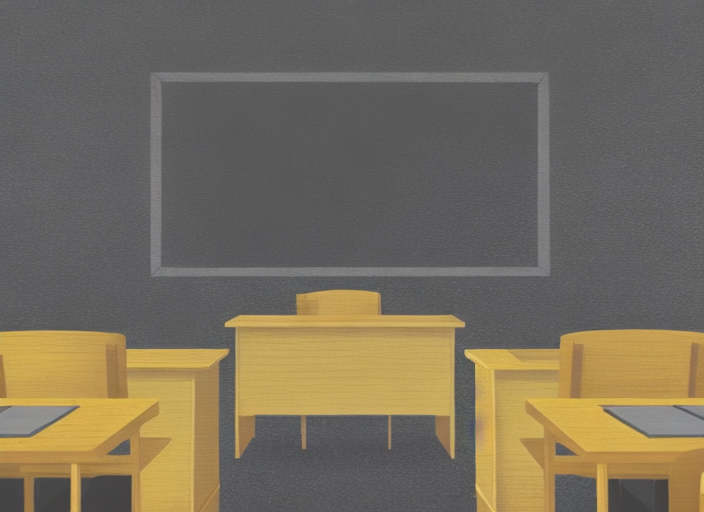

In [73]:
image = model.generate_image_from_sample(
    image_path = '/kaggle/input/mlsd-lines/classroom.jpg',
    prompt = 'classroom with empty blackboard, studio ghibli style',
    outfile = 'classroom'
)

Image.open('/kaggle/working/images/classroom_out.png')